# Data Structuring and Pruning

In [2]:
# Load datasets

import json
import pathlib
import importlib
from collections import defaultdict, Counter
import pyupset as pyu
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import viccdb
%matplotlib inline

In [3]:
# reload module and load data
importlib.reload(viccdb)
vdb = viccdb.ViccDb()
vdb.report_groups()

brca: 5717 (25.3% of total)
cgi: 1073 (4.7% of total)
civic: 3340 (14.8% of total)
jax: 5754 (25.4% of total)
molecularmatch: 2085 (9.2% of total)
oncokb: 4048 (17.9% of total)
pmkb: 600 (2.7% of total)
22617 total associations


In [4]:
# for now, omit brca from analysis
brca = vdb.select(lambda x: x['source'] == 'brca')
core_vdb = vdb - brca
core_vdb.report_groups()

cgi: 1073 (6.3% of total)
civic: 3340 (19.8% of total)
jax: 5754 (34.0% of total)
molecularmatch: 2085 (12.3% of total)
oncokb: 4048 (24.0% of total)
pmkb: 600 (3.6% of total)
16900 total associations


In [5]:
# remove biological associations
oncokb_biological = core_vdb.select(lambda x: x['source'] == 'oncokb' and 'biological' in x['raw'])
oncokb_biological.report_groups(core_vdb)
core_vdb = core_vdb - oncokb_biological

oncokb: 3801 (93.9% of superset)
Total: 3801 (22.5% of superset)


## Evidence Uniqueness

This section deals with non-unique entries from the database. This is a temporary measure until the importers are fixed. As such, it uses private variables and non-standard methods to hack around the built-in uniqueness assumptions that are violated by these data. Remove this entire section once the source hash checks pass.

In [6]:
core_vdb.report_groups()

cgi: 1073 (8.2% of total)
civic: 3340 (25.5% of total)
jax: 5754 (43.9% of total)
molecularmatch: 2085 (15.9% of total)
oncokb: 247 (1.9% of total)
pmkb: 600 (4.6% of total)
13099 total associations


In [7]:
# Non-unique raw entries
raw_duplicates = core_vdb.select(lambda x: len(core_vdb._hashed[hash(x)]) > 1)
raw_duplicates.report_groups(core_vdb)

cgi: 2 (0.2% of superset)
pmkb: 311 (51.8% of superset)
Total: 313 (2.4% of superset)


In [8]:
cgi_dups = raw_duplicates.by_source('cgi')
cgi_clean = [x for x in cgi_dups if x['raw']['Drug status']]
test = viccdb.ViccDb([x for x in core_vdb if x not in cgi_dups] + list(cgi_clean))
test.report_groups(core_vdb)

cgi: 1072 (99.9% of superset)
civic: 3340 (100.0% of superset)
jax: 5754 (100.0% of superset)
molecularmatch: 2085 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 600 (100.0% of superset)
Total: 13098 (100.0% of superset)


In [9]:
# Test matches expectation, moving to core
core_vdb = test

In [10]:
pmkb_dups = raw_duplicates.by_source('pmkb')

In [11]:
len(pmkb_dups._hashed)

82

In [12]:
len(pmkb_dups)

311

In [13]:
merged_associations = list()
for hash_key, equivalent_associations in pmkb_dups._hashed.items():
    root_association = equivalent_associations.pop()
    for other_association in equivalent_associations:
        root_association['features'].append(other_association['features'][0])
    merged_associations.append(root_association)

In [14]:
test = viccdb.ViccDb([x for x in core_vdb if x not in merged_associations] + list(merged_associations))
test.report_groups(core_vdb)

cgi: 1072 (100.0% of superset)
civic: 3340 (100.0% of superset)
jax: 5754 (100.0% of superset)
molecularmatch: 2085 (100.0% of superset)
oncokb: 247 (100.0% of superset)
pmkb: 371 (61.8% of superset)
Total: 12869 (98.3% of superset)


In [15]:
x = len(core_vdb.by_source('pmkb')) - len(pmkb_dups) + len(pmkb_dups._hashed)
print("Expecting {} associations for PMKB".format(x))

Expecting 371 associations for PMKB


In [16]:
# Test matches expectation, moving to core
core_vdb = test

## Evidence filtering

Removal of all evidence without associated publications, followed by removal of all associations without evidence.

In [17]:
def clean_refs(association):
    evidences = association['association']['evidence']
    evidence_indices_to_delete = list()
    for i, evidence in enumerate(evidences):
        assert isinstance(publications, list)
        publications = [x for x in evidence['info']['publications'] if x]
        evidence['info']['publications'] = publications
        if not publications:
            evidence_indices_to_delete.append(i)
    for index in sorted(evidence_indices_to_delete, reverse=True):
        del association['association']['evidence'][index]

map(clean_refs, core_vdb)
core_missing_ref = core_vdb.select(lambda x: not any(x.publications))
core_missing_ref.report_groups(core_vdb)
core_vdb = core_vdb - core_missing_ref

jax: 8 (0.1% of superset)
molecularmatch: 5 (0.2% of superset)
Total: 13 (0.1% of superset)


In [18]:
core_vdb.report_groups()

cgi: 1072 (8.3% of total)
civic: 3340 (26.0% of total)
jax: 5746 (44.7% of total)
molecularmatch: 2080 (16.2% of total)
oncokb: 247 (1.9% of total)
pmkb: 371 (2.9% of total)
12856 total associations


In [19]:
# All associations should have an evidence level

core_vdb.select(lambda x: not x.evidence_level).report_groups(core_vdb)

Total: 0 (0.0% of superset)


## Feature coordinates

What follows is a detailed look at associations without start and end coordinates after normalization, and a set of regular expression filters to separate out these associations into chunks that can be annotated with gene- or exon-level coordinates, as appropriate.

In [20]:
# Associations with more than 1 feature
x = core_vdb.select(lambda x: len(x.features) > 1)
x.report_groups(vdb)

cgi: 225 (21.0% of superset)
jax: 1789 (31.1% of superset)
molecularmatch: 17 (0.8% of superset)
oncokb: 35 (0.9% of superset)
pmkb: 82 (13.7% of superset)
Total: 2148 (9.5% of superset)


In [21]:
# Associations without at least 1 complete feature
no_features = core_vdb.select(lambda x: len(x.features) == 0)
no_features.report_groups(vdb)

cgi: 4 (0.4% of superset)
civic: 3 (0.1% of superset)
jax: 12 (0.2% of superset)
molecularmatch: 17 (0.8% of superset)
oncokb: 4 (0.1% of superset)
pmkb: 2 (0.3% of superset)
Total: 42 (0.2% of superset)


In [22]:
vdb[0]['association']['phenotype']

{'description': 'lung adenocarcinoma',
 'family': 'lung cancer',
 'type': {'id': 'DOID:3910',
  'source': 'http://purl.obolibrary.org/obo/doid',
  'term': 'lung adenocarcinoma'}}

In [23]:
# Associations with coordinate features
coord_featured = core_vdb - no_features
coord_featured.report_groups(core_vdb)

cgi: 1068 (99.6% of superset)
civic: 3337 (99.9% of superset)
jax: 5734 (99.8% of superset)
molecularmatch: 2063 (99.2% of superset)
oncokb: 243 (98.4% of superset)
pmkb: 369 (99.5% of superset)
Total: 12814 (99.7% of superset)


In [24]:
# Associations with invalid coordinates
invalid_features = core_vdb.select(lambda x: any([f.start > f.end for f in x.features]))
invalid_features.report_groups(core_vdb)

civic: 2 (0.1% of superset)
pmkb: 2 (0.5% of superset)
Total: 4 (0.0% of superset)


In [25]:
core_vdb = core_vdb - invalid_features

In [26]:
[x.features for x in invalid_features.by_source('pmkb')]

[[<class 'viccdb.GenomicFeature'>: GRCh37:19:1207090:1206915:STK11 codon(s) 60-1 deletion],
 [<class 'viccdb.GenomicFeature'>: GRCh37:19:1207090:1206915:STK11 codon(s) 60-1 deletion]]

### Remainder of section is inactivated code for identifying associations without coordinates

import re

def feature_filter(re_obj, associations):
    # report matches and return non-matches
    found = list(filter(lambda x: re_obj.search(x['feature_names']) is not None, associations))
    not_found = list(filter(lambda x: re_obj.search(x['feature_names']) is None, associations))
    report_groups(found)
    return(not_found)

amp_re = re.compile(r'(amplification)|(loss)|(amp)', re.IGNORECASE)
remainder = feature_filter(amp_re, no_partial_coord_featured_with_feature_names)

fusion_re = re.compile(r'(\w{2,}-\w{2,})|(fusion)', re.IGNORECASE)
r2 = feature_filter(fusion_re, remainder)

ppm_re = re.compile(r'\w+(:| )[a-z]\d+[a-z]?(fs\*?)?$', re.IGNORECASE)
r3 = feature_filter(ppm_re, r2)

indel_re = re.compile(r'\w+(:| )\w+(ins\w+)|(del($|ins\w+))|(dup$)')
r4 = feature_filter(indel_re, r3)

bucket_re = re.compile(r'[A-Z0-9]+( (in)?act)?( oncogenic)? mut((ant)|(ation))?$')
r5 = feature_filter(bucket_re, r4)

exon_re = re.compile(r'exon', re.IGNORECASE)
r6 = feature_filter(exon_re, r5)

expression_re = re.compile(r'(exp)|(^\w+ (pos(itive)?)|(neg(ative)?)|(biallelic inactivation)$)|(truncating)|(deletion)', re.IGNORECASE)
r7 = feature_filter(expression_re, r6)

report_groups(r7)

get_feature_names([x for x in r7 if x['source'] == 'cgi'])

## Diseases

In [27]:
disease_missing = core_vdb.select(lambda x: x.disease is None)
disease_missing.report_groups(core_vdb)

civic: 1 (0.0% of superset)
Total: 1 (0.0% of superset)


In [28]:
disease_missing[0]['association']

{'description': 'Pericytoma with t(7;12) is a soft tissue tumor characterized by fusion of the ACTB and GLI genes through the translocation t(7;12)(p22;q13). In this study the genomic breakpoints of 5 cases were characterized.',
 'environmentalContexts': [],
 'evidence': [{'description': 'Positive',
   'evidenceType': {'id': '1844', 'sourceName': 'CIVIC'},
   'info': {'publications': ['http://www.ncbi.nlm.nih.gov/pubmed/15555571']}}],
 'evidence_label': 'B',
 'evidence_level': 2,
 'phenotype': {'description': 'Pericytoma',
  'family': 'Uncategorized-PHN',
  'id': 'http://www.disease-ontology.org/'},
 'publication_url': ['http://www.ncbi.nlm.nih.gov/pubmed/15555571'],
 'response_type': 'Positive',
 'source_link': 'https://civic.genome.wustl.edu/events/genes/2279/summary/variants/780/summary'}

## Drugs

In [29]:
drugs_missing = core_vdb.select(lambda x: len(x.drugs) == 0)
drugs_missing.report_groups(core_vdb)

cgi: 112 (10.4% of superset)
civic: 1259 (37.7% of superset)
jax: 457 (8.0% of superset)
molecularmatch: 120 (5.8% of superset)
oncokb: 8 (3.2% of superset)
pmkb: 369 (100.0% of superset)
Total: 2325 (18.1% of superset)


## Genes

In [73]:
ambiguous = list()
for a in core_vdb:
    try:
        a.genes
    except AssertionError:
        ambiguous.append(a)

assert len(ambiguous) == 0  # Ensure there are no ambiguous genes from knowledgebases

## Cache

Saving core_vdb to cache for testing.

In [30]:
core_vdb.cache_data()

# Knowledgebase Comparison

## Publications

### All publications

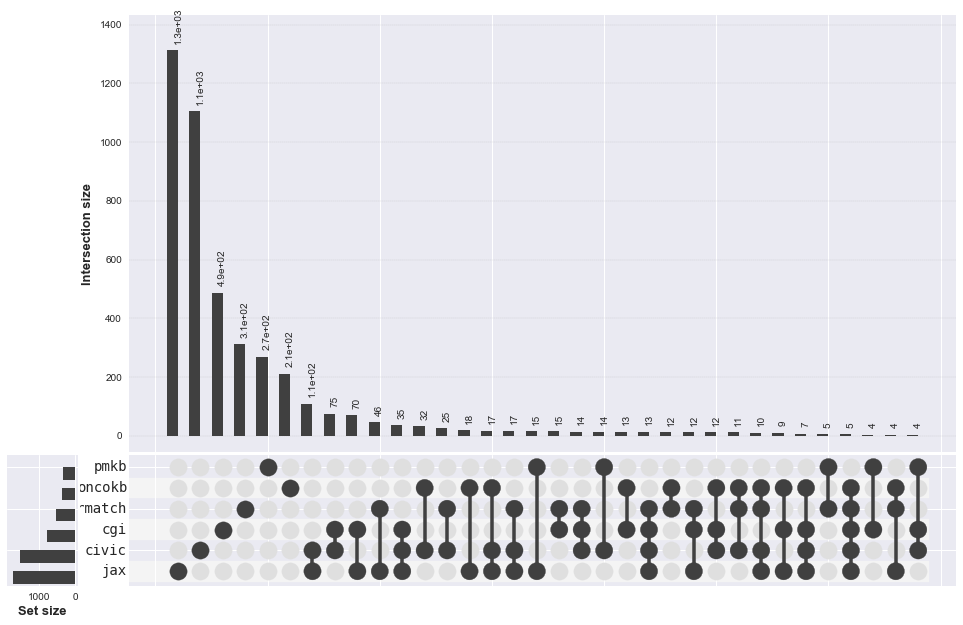

In [31]:
x = core_vdb.plot_element_by_source('publications', min_bound=4)
# f = x['figure']
# f.savefig('out/publications.pdf')

In [32]:
# Publications uniquely cited
data = x['input_data']
total = 0
for source in data:
    publications_from_elsewhere = set()
    for source2 in data:
        if source == source2:
            continue
        publications_from_elsewhere.update(data[source2])
    unique = data[source] - publications_from_elsewhere
    print("{}: {} resource-specific publications".format(source, len(unique)))
    total += len(unique)
print("{} ({:.2%}) total resource-specific publications".format(total, total / len(set.union(*(data.values())))))

molecularmatch: 311 resource-specific publications
civic: 1105 resource-specific publications
pmkb: 268 resource-specific publications
oncokb: 211 resource-specific publications
jax: 1312 resource-specific publications
cgi: 486 resource-specific publications
3693 (84.88%) total resource-specific publications


In [33]:
x = core_vdb.element_by_source_stats('publications')
x['ubiquitous'] # Bose et al. Cancer Discovery 2013

3693 / 4351 (84.88%) of publications are represented in only 1 resource.
203 / 4351 (4.67%) of publications are represented in the majority of (3) resources.
1 / 4351 (0.02%) of publications are represented across all resources.


{<class 'viccdb.Publication'>: 23220880}

### PMIDs

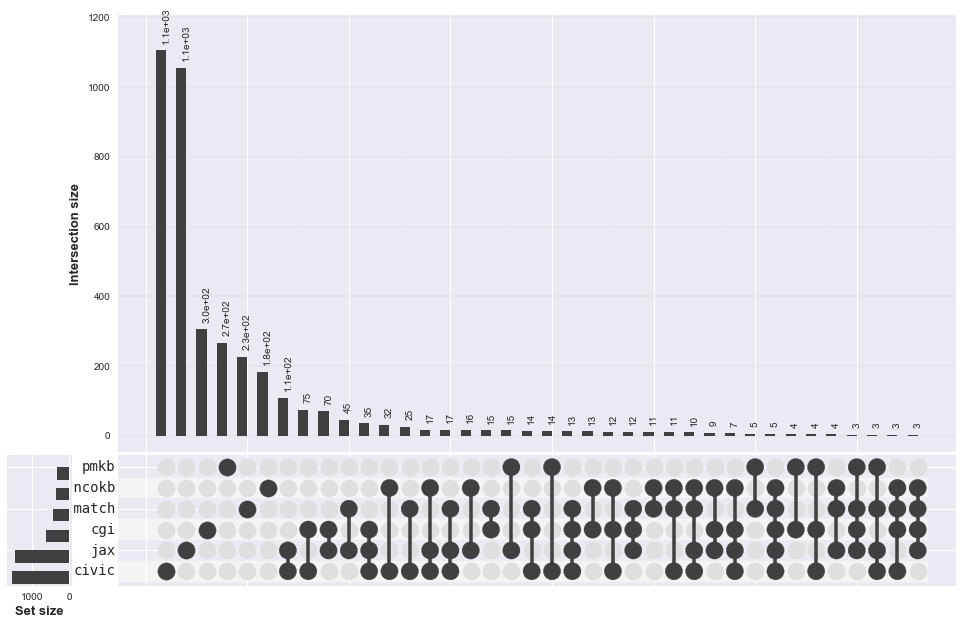

In [34]:
x = core_vdb.plot_element_by_source('publications', lambda x: x.pmid, min_bound=3)
# f = x['figure']
# f.savefig('out/pmids.pdf')

In [35]:
x = core_vdb.element_by_source_stats('publications', lambda x: x.pmid)
x['ubiquitous'] # Bose et al. Cancer Discovery 2013

3141 / 3795 (82.77%) of publications are represented in only 1 resource.
203 / 3795 (5.35%) of publications are represented in the majority of (3) resources.
1 / 3795 (0.03%) of publications are represented across all resources.


{<class 'viccdb.Publication'>: 23220880}

## Genes

In [36]:
no_genes = core_vdb.select(lambda x: not x.genes)
no_genes.report_groups(core_vdb)

cgi: 1 (0.1% of superset)
molecularmatch: 5 (0.2% of superset)
oncokb: 2 (0.8% of superset)
Total: 8 (0.1% of superset)


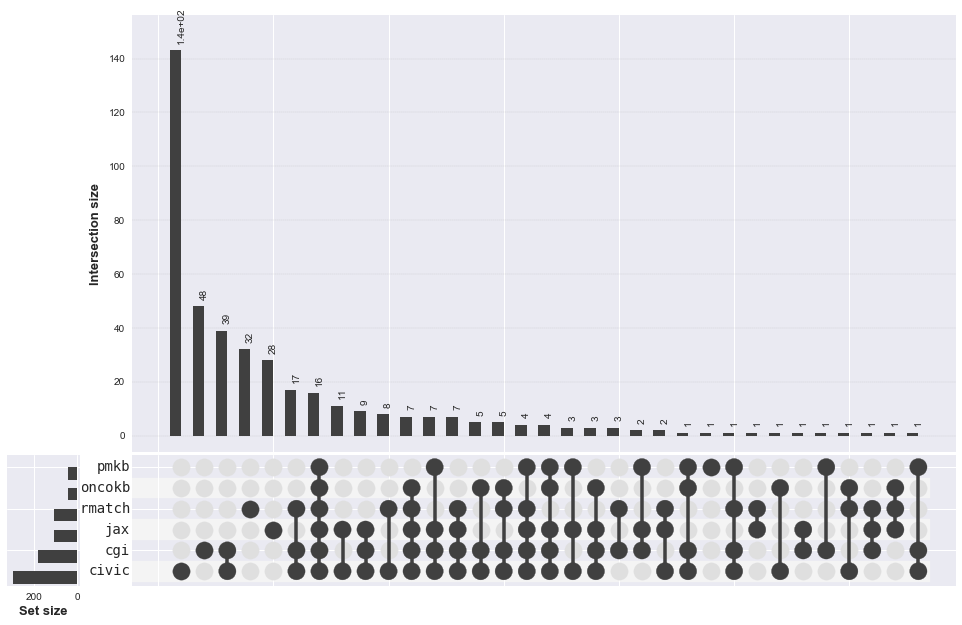

In [37]:
with_genes = core_vdb - no_genes
x = with_genes.plot_element_by_source('genes')
# f = x['figure']
# f.savefig('out/genes.pdf')

In [38]:
x = with_genes.element_by_source_stats('genes')
x['ubiquitous']

252 / 414 (60.87%) of genes are represented in only 1 resource.
97 / 414 (23.43%) of genes are represented in the majority of (3) resources.
16 / 414 (3.86%) of genes are represented across all resources.


{<class 'viccdb.Gene'>: EGFR,
 <class 'viccdb.Gene'>: ERBB2,
 <class 'viccdb.Gene'>: FGFR3,
 <class 'viccdb.Gene'>: FGFR2,
 <class 'viccdb.Gene'>: FLT3,
 <class 'viccdb.Gene'>: ALK,
 <class 'viccdb.Gene'>: ABL1,
 <class 'viccdb.Gene'>: KIT,
 <class 'viccdb.Gene'>: KRAS,
 <class 'viccdb.Gene'>: MET,
 <class 'viccdb.Gene'>: NOTCH1,
 <class 'viccdb.Gene'>: NRAS,
 <class 'viccdb.Gene'>: PDGFRA,
 <class 'viccdb.Gene'>: PIK3CA,
 <class 'viccdb.Gene'>: PTEN,
 <class 'viccdb.Gene'>: BRAF}

## Features

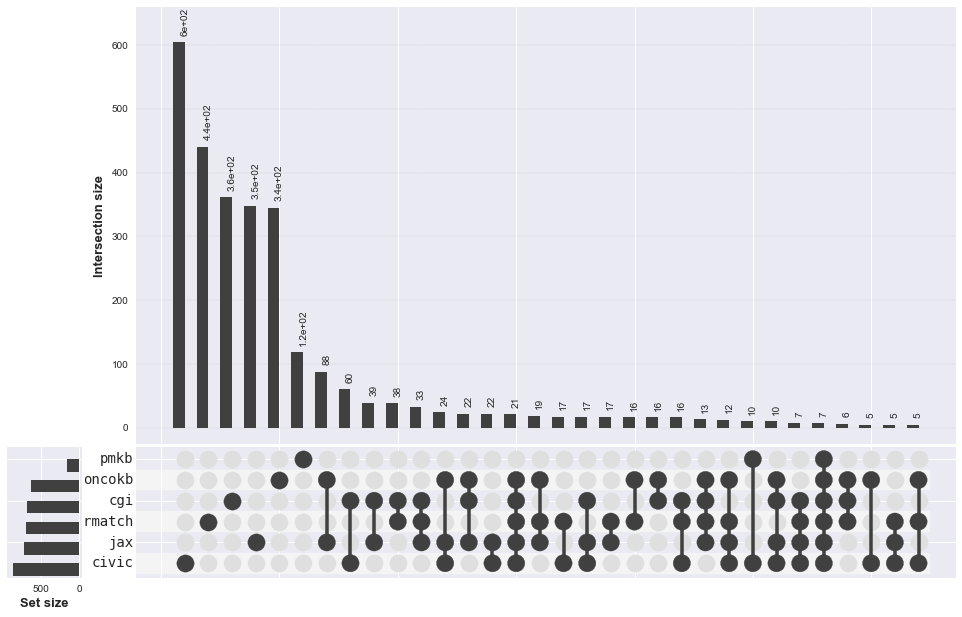

In [39]:
x = core_vdb.plot_element_by_source('features', min_bound=5)
# f = x['figure']
# f.savefig('out/features.pdf')

In [40]:
x = core_vdb.element_by_source_stats('features')

2220 / 2800 (79.29%) of features are represented in only 1 resource.
239 / 2800 (8.54%) of features are represented in the majority of (3) resources.
7 / 2800 (0.25%) of features are represented across all resources.


### Hierarchical search
Existing method is to find an exact match of any features for an association. Below we demonstrate gains through hierarchical search of GenomicFeatures, a core result of this effort.

In [42]:
hits = core_vdb.search_features(chromosome=7, start=140453136, end=140453136, reference_name='GRCh37')

v600k = [x['best_match']['p'] for x in hits if x['best_match']['feature'].name.endswith('V600K')]
len(v600k)

26

In [43]:
unique_features = set()
x = [x.features for x in core_vdb]
for fset in x:
    unique_features.update(fset)
unique_features = list(unique_features)
len(unique_features)

2800

In [44]:
# This is a computationally expensive operation (~1 minute for the 2800 searches). Could be sped up through indexed searching.

feature_hits = dict()
for feature in unique_features:
    feature_hits[feature] = core_vdb.search_features(genomic_feature=feature)


In [45]:
ranking = viccdb.ViccDb.MATCH_RANKING
hits_by_type = Counter()
sources_by_type = defaultdict(Counter)
for f in unique_features:
    for match_type in ranking:
        typed_hits = [x for x in feature_hits[f] if ranking.index(x['best_match']['type']) <= ranking.index(match_type)]
        if match_type != 'exact' or f.alt:
            assert len(typed_hits) >= 1, "Expected at least a self-match for feature {}".format(f)
        hits_by_type[match_type] += len(typed_hits)
        sources = set([hit['association'].source for hit in typed_hits])
        if sources:
            sources_by_type[len(sources)][match_type] += 1
hits_by_type

Counter({'exact': 14915,
         'focal': 52026,
         'positional': 26433,
         'regional': 211808})

In [46]:
sources_by_type

defaultdict(collections.Counter,
            {1: Counter({'exact': 1999,
                      'focal': 1788,
                      'positional': 2033,
                      'regional': 490}),
             2: Counter({'exact': 281,
                      'focal': 414,
                      'positional': 388,
                      'regional': 426}),
             3: Counter({'exact': 137,
                      'focal': 281,
                      'positional': 237,
                      'regional': 452}),
             4: Counter({'exact': 45,
                      'focal': 158,
                      'positional': 75,
                      'regional': 681}),
             5: Counter({'exact': 23,
                      'focal': 102,
                      'positional': 52,
                      'regional': 446}),
             6: Counter({'exact': 7,
                      'focal': 57,
                      'positional': 15,
                      'regional': 305})})

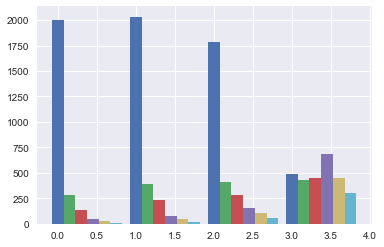

In [56]:
fig, ax = plt.subplots()

source_counts = sorted(sources_by_type)
groups = viccdb.ViccDb.MATCH_RANKING
width = 0.15
plot_elements = list()
for i, source_count in enumerate(source_counts):
    type_counts = sources_by_type[source_count]
    x = [type_counts[k] for k in groups]
    p = ax.bar(ind + width*i, x, width)
    plot_elements.append(p)
plt.show()

In [48]:
c = Counter()
for f in unique_features:
    if len(f) > 9 and len(f) < 100:
        l = '10-99'
    elif len(f) >= 100:
        l = '100+'
    else:
        l = len(f)
    c[l] += 1
c

Counter({1: 1919,
         '100+': 503,
         2: 154,
         '10-99': 108,
         3: 92,
         6: 3,
         8: 5,
         9: 1,
         5: 6,
         4: 7,
         7: 2})

### Sequence Ontology

In [49]:
count = Counter()
for association in core_vdb:
    for feature in association.features:
        count[feature.so.get('name', 'Uncategorized')] += 1

In [50]:
count.most_common(10)

[('Uncategorized', 8310),
 ('missense_variant', 2986),
 ('fusion', 2071),
 ('stop_gained', 1727),
 ('substitution', 1244),
 ('feature_amplification', 440),
 ('wild_type', 391),
 ('loss_of_function_variant', 242),
 ('copy_number_loss', 207),
 ('positively_autoregulated', 197)]

In [51]:
(5052 + 3263) / sum(count.values())

0.42573344938815216

In [52]:
# Associations lacking any sequence ontology ID

def no_soid(association):
    x = [feature.so.get('name', 'Uncategorized') == 'Uncategorized' for feature in association.features]
    return all(x)

no_soid_group = core_vdb.select(no_soid)
no_soid_group.report_groups(core_vdb)

cgi: 523 (48.8% of superset)
civic: 373 (11.2% of superset)
jax: 2302 (40.1% of superset)
molecularmatch: 449 (21.6% of superset)
oncokb: 78 (31.6% of superset)
pmkb: 110 (29.8% of superset)
Total: 3835 (29.8% of superset)


In [53]:
# Associations lacking at least one sequence ontology ID

def missing_soid(association):
    x = [feature.so.get('name', 'Uncategorized') == 'Uncategorized' for feature in association.features]
    return any(x)

missing_soid_group = core_vdb.select(missing_soid)
missing_soid_group.report_groups(core_vdb)

cgi: 519 (48.4% of superset)
civic: 370 (11.1% of superset)
jax: 3123 (54.4% of superset)
molecularmatch: 433 (20.8% of superset)
oncokb: 74 (30.0% of superset)
pmkb: 108 (29.3% of superset)
Total: 4627 (36.0% of superset)


In [54]:
partial_soid_group = missing_soid_group - no_soid_group
partial_soid_group.report_groups(core_vdb)

jax: 833 (14.5% of superset)
molecularmatch: 1 (0.0% of superset)
Total: 834 (6.5% of superset)


In [55]:
partial_soid_group[0].features[2].so

{'hierarchy': ['SO:0000110', 'SO:0002072', 'SO:0001059', 'SO:0000248'],
 'name': 'copy_number_variation',
 'parent_name': 'sequence_feature',
 'parent_soid': 'SO:0000110',
 'soid': 'SO:0001019'}